In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

Using GPU 0: GeForce RTX 2080 Ti
Driver: 418.56


In [3]:
x = np.load('cat_face.npy')
x = (x * 2) - 1
train_loader = FromNumpy((x, x), 1, 64)

In [4]:
runner = Runner(GANModel(AutoGAN_G(), AutoGAN_D(), latent_vector_len=100),#, condition_vector_len=[10, 10], condition_onehot=True),
                train_loader, 
                None, 
                'adam_gan',
                GANLoss('vanilla'),
                monitor_state='g_loss',
                monitor_mode='min')

In [5]:
runner.init_model('default')

In [6]:
runner.fit(150)

Output()

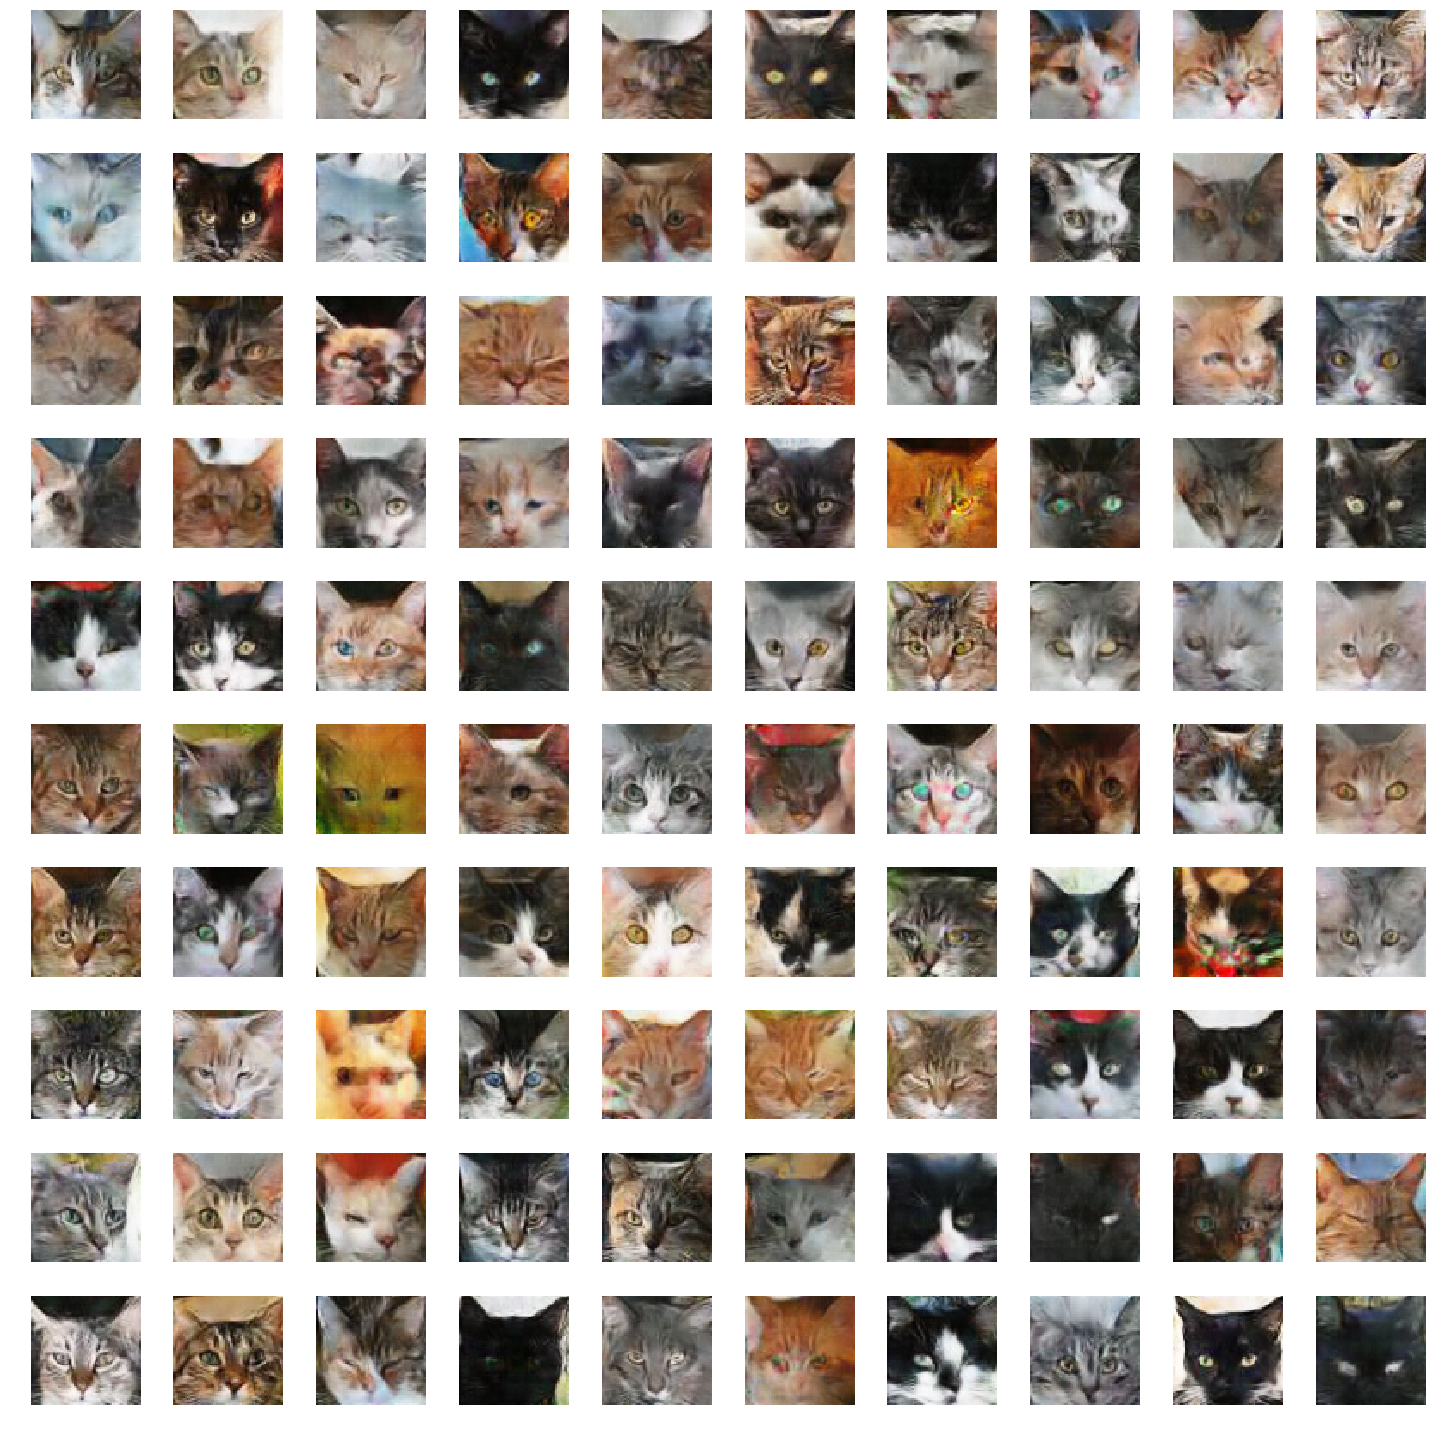

In [10]:
# img = runner.model.sample(100, condition_data=list(range(10))*10)
runner.model.cpu()
img = runner.model.sample(100)
img = (img+1)/2
import matplotlib.pyplot as plt
fig, arr = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    r = img[i].detach().cpu().numpy().transpose(1,2,0)
    arr[i//10][i%10].axis('off')
    arr[i//10][i%10].imshow(r)#, cmap='gray')
plt.tight_layout()
plt.show()

In [8]:
runner.report()

Experiment: default
Checkpoints are saved in ./checkpoint/default


Epoch,train_d_loss,train_g_loss,saved
1,1.136966,2.998267,*
2,1.152850,1.706837,*
3,1.186702,1.913553,
4,1.093348,2.098034,
5,1.089262,2.422691,
6,1.018281,2.341200,
7,1.015235,2.709186,
8,0.980866,2.405236,
9,1.014319,2.560444,
10,0.988967,2.266193,
